In [1]:
import os
os.chdir(os.path.expanduser("/users/grad/msaad/norm-analysis-clm"))

In [2]:
from custom_transformers import custom_modelling_roberta
from transformers import RobertaTokenizer
import torch

/net/fs-v2.cs.lan/export/grad/msaad/norm-analysis-clm/norm_analysis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")

In [5]:
model = custom_modelling_roberta.RobertaModel.from_pretrained("microsoft/codebert-base")

In [6]:
model.to(device)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [7]:
code_tokens=tokenizer.tokenize("def max(a,b): if a>b: return a else return b")

In [8]:
tokens=[tokenizer.cls_token]+code_tokens+[tokenizer.eos_token]

In [9]:
tokens_ids=torch.tensor([tokenizer.convert_tokens_to_ids(tokens)]).to(device)

In [10]:
print(tokens)
print(tokens_ids)

['<s>', 'def', 'Ġmax', '(', 'a', ',', 'b', '):', 'Ġif', 'Ġa', '>', 'b', ':', 'Ġreturn', 'Ġa', 'Ġelse', 'Ġreturn', 'Ġb', '</s>']
tensor([[    0,  9232, 19220,  1640,   102,     6,   428,  3256,   114,    10,
         15698,   428,    35,   671,    10,  1493,   671,   741,     2]],
       device='cuda:0')


In [11]:
with torch.no_grad():
    last_hidden_state, pooler_output, hidden_states, attentions, norms = model(input_ids=tokens_ids, output_hidden_states=True, output_attentions=True, output_norms=True)

In [12]:
# Returned variable "norms" is a tuple which has 12 elements (equal to the number of layers).
print(type(norms))
print(len(norms))

<class 'tuple'>
12


In [13]:
# Each element is a tuple which consists of 3 elements: ||f(x)||, ||αf(x)||, and ||Σαf(x)||.
layer = 7
print(type(norms[layer-1]))
print(len(norms[layer-1]))

fx_norm, afx_norm, summed_afx_norm = norms[layer-1]

<class 'tuple'>
3


In [14]:
# shape of fx_norm (||f(x)||) is (batch, num_heads, seq_length)
print("shape of ||f(x)||:", fx_norm.size())

shape of ||f(x)||: torch.Size([1, 12, 19])


In [15]:
# shape of afx_norm (||αf(x)||) is (batch, num_heads, seq_length, seq_length)
print("shape of ||αf(x)||:", afx_norm.size())

shape of ||αf(x)||: torch.Size([1, 12, 19, 19])


In [16]:
# shape of summed_afx_norm (||Σαf(x)||) is (batch, seq_length, seq_length)
print("shape of ||Σαf(x)||:", summed_afx_norm.size())

shape of ||Σαf(x)||: torch.Size([1, 19, 19])


In [17]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

layer = 7
head = 5

### Attention weight visualization (Head-level visualization)

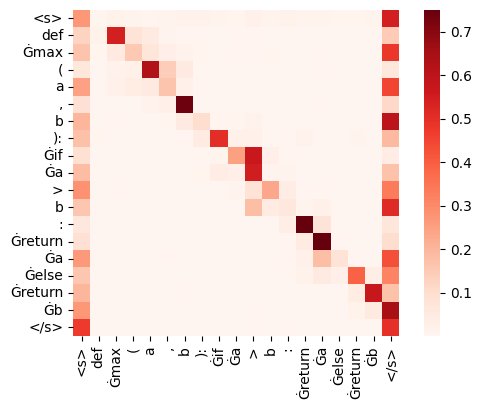

In [19]:
plt.figure() 
attention = attentions[layer-1][0][head-1].cpu().numpy()
df = pd.DataFrame(attention,columns=tokens,index=tokens)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Norm of the weighted vectors (||αf(x)||) visualization (Head-level visualization)

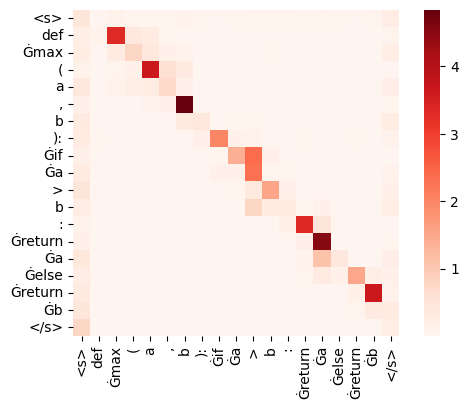

In [20]:
plt.figure() 
afx_norm = norms[layer-1][1]
norm = afx_norm[0][head-1].cpu().numpy()
df = pd.DataFrame(norm,columns=tokens,index=tokens)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Attention weight visualization (Layer-level visualization)

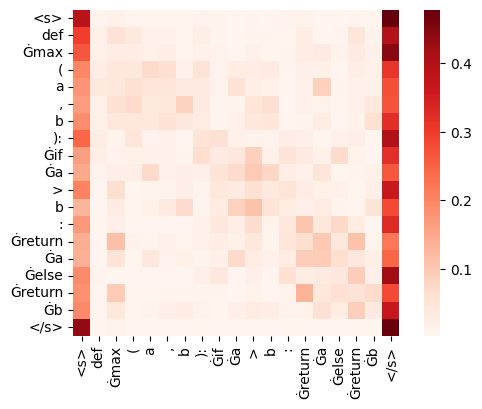

In [21]:
plt.figure() 
attention = attentions[layer-1][0].mean(0).cpu().numpy()
df = pd.DataFrame(attention,columns=tokens,index=tokens)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

### Norm of the summed weighted vectors (||Σ αf(x)||) visualization (Layer-level visualization)

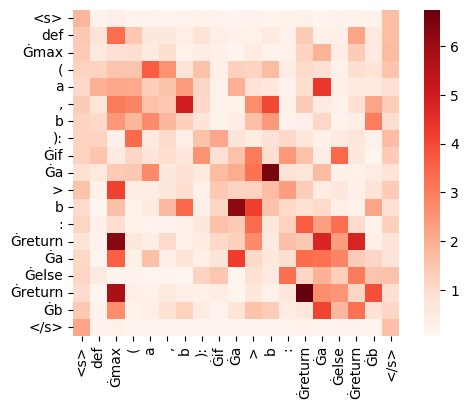

In [22]:
plt.figure() 
summed_afx_norm = norms[layer-1][2]
norm = summed_afx_norm[0].cpu().numpy()
df = pd.DataFrame(norm,columns=tokens,index=tokens)
sns.heatmap(df,cmap="Reds",square=True)
plt.gcf().subplots_adjust(bottom=0.2)